## Travel times in 2D heterogenous media: Borehole example  #

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time
from tqdm import tqdm

--------

## Fast Marching Wave Front Tracking


The wave front tracker routines solves boundary value ray tracing problems into 2D heterogeneous wavespeed media, defined by continuously varying velocity model calculated by 2D cubic B-splines.

Follows similar structure and makes use of code borrowed from Andrew Valentine's rayTracer.py.

#### Utility routines for building velocity models

In [2]:
# build test velocity models
from scipy.stats import multivariate_normal

def get_spherical_model(extent,nx,ny): # build two spherical anomaly velocity model
    # set up velocity model
    vc1 = 1700.                           # velocity of circle 1
    vc2 = 2300.                           # velocity of circle 2
    c1,rad1 = np.array([7.0,22.]),3.0     # location and radius of centre of first circle
    c2,rad2 = np.array([12.0,10.]),4.0    # location and radius of centre of first circle
    #nx,ny = 32,48                         # model discretization
    mb = 2000.*np.ones([nx,ny])           # velocity model in m/s
    dx = (extent[1]-extent[0])/nx                           # cell width
    dy = (extent[3]-extent[2])/ny                           # cell height
    xc = np.linspace(extent[0]+dx/2.,extent[1]-dx/2.,nx)    # cell centre
    yc = np.linspace(extent[2]+dy/2.,extent[3]-dy/2.,ny)    # cell centre
    X,Y = np.meshgrid(xc, yc)   # cell centre mesh
    m = np.copy(mb)
    a = (X-c1[0])**2 + (Y-c1[1])**2 < rad1**2
    m[a.T] = vc1
    b = (X-c2[0])**2 + (Y-c2[1])**2 < rad2**2
    m[b.T] = vc2
    return m

def get_gauss_model(extent,nx,ny,factor=1.): # build two gaussian anomaly velocity model
    vc1 = 1700.*factor                           # velocity of circle 1
    vc2 = 2300.*factor                           # velocity of circle 2
    vb = 2000.*factor                            # background velocity
    dx = (extent[1]-extent[0])/nx                           # cell width
    dy = (extent[3]-extent[2])/ny                           # cell height
    xc = np.linspace(extent[0],extent[1],nx)    # cell centre
    yc = np.linspace(extent[2],extent[3],ny)    # cell centre
    X,Y = np.meshgrid(xc, yc,indexing='ij')     # cell centre mesh

    # Multivariate Normal
    dex = extent[1]-extent[0]
    dey = extent[3]-extent[2]
    c1x = extent[0] + (7.0-extent[0])*dex/20.
    c2x = extent[0] + (12.0-extent[0])*dex/20.
    c1y = extent[0] + (22.0-extent[0])*dey/30.
    c2y = extent[0] + (10.0-extent[0])*dey/30.
    s1 = 6.0*dex/20.
    s2 = 10.0*dex/20.
    c1,sig1 = np.array([c1x,c1y])*factor,s1*(factor**2)      # location and radius of centre of first circle
    c2,sig2 = np.array([c2x,c2y])*factor,s2*(factor**2)     # location and radius of centre of first circle
    rv1 = multivariate_normal(c1, [[sig1, 0], [0, sig1]])
    rv2 = multivariate_normal(c2, [[sig2, 0], [0, sig2]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    gauss1,gauss2 = rv1.pdf(pos),rv2.pdf(pos)
    return   vb*np.ones([nx,ny])  + (vc1-vb)*gauss1/np.max(gauss1) + (vc2-vb)*gauss2/np.max(gauss2)


----

### Example: Cross borehole velocity model

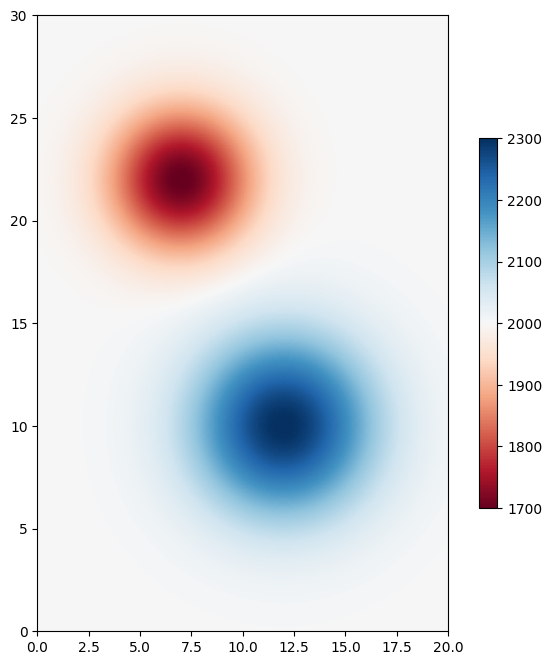

In [3]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
g2 = pyfm2d.BasisModel(m, extent=extent)
velocity = g2.get_velocity()
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300))

In [4]:
# build sources and receivers for model 2
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    80, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(recs)  # number of sources

In [5]:
# run wave front tracker
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    earthradius=6371.0,
)
import time

start = time.time()
result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
end = time.time()
print("wall time:",end - start)

print(" Number of paths calculated = ", len(result.paths))
print(" Number of travel times calculated = ", len(result.ttimes))
print(" Shape of frechet matrix = ", result.frechet.shape)




wall time: 4.3371901512146
 Number of paths calculated =  800
 Number of travel times calculated =  800
 Shape of frechet matrix =  (800, 1536)


In [6]:
start = time.time()
result_list = pyfm2d.calc_wavefronts(velocity, recs, srcs,nthreads=2,extent=extent, options=options)
end = time.time()
print("wall time:",end - start)


wall time: 2.51525616645813


In [7]:
print(result_list)

WaveTrackerResult(ttimes=array([0.0100453 , 0.01021847, 0.01047566, 0.01085238, 0.01141386,
       0.01216248, 0.01305832, 0.014058  , 0.01512919, 0.01625051,
       0.0100199 , 0.01016479, 0.01039776, 0.0107577 , 0.01130815,
       0.0120488 , 0.01293825, 0.01393235, 0.01499831, 0.01611459,
       0.00999864, 0.0101128 , 0.01031773, 0.01065828, 0.01119585,
       0.01192718, 0.01280923, 0.013797  , 0.0148572 , 0.01596807,
       0.0099816 , 0.01006605, 0.01024435, 0.01056691, 0.01109251,
       0.01181501, 0.0126899 , 0.01367137, 0.01472568, 0.01583089,
       0.0099665 , 0.01002146, 0.01017434, 0.01047952, 0.01099344,
       0.0117073 , 0.01257509, 0.01355017, 0.01459834, 0.01569747,
       0.0099546 , 0.00997964, 0.01010598, 0.01039326, 0.01089496,
       0.01159958, 0.01245971, 0.01342793, 0.01446954, 0.01556228,
       0.00993811, 0.00990055, 0.00997366, 0.01022402, 0.01069961,
       0.01138399, 0.01222701, 0.01317964, 0.0142063 , 0.01528471,
       0.00994499, 0.00993939, 0.0100